![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

## AIML Online Capstone - Pneumonia Detection Challenge

## Project Description:

In this capstone project, the goal is to build a pneumonia detection system, to locate the position of
inflammation in an image.

Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear
black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia
related.

In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates
that while pneumonia was determined not to be present, there was nonetheless some type of
abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

**Dicom original images:** - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data.


Details about the data and dataset files are given in below link,

   https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

**Team Members:**
- Sothing Shimrah
- Vibi Vijayan
- Karthick Lakshman
- Bhavadas


###Pre-Processing, Data Visualization, EDA


**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Current working directory**

In [2]:
import os, sys 
project_path = "/content/drive/MyDrive/Capstone/"
os.chdir(project_path)
# Add the path to the sys.path for this session
sys.path.append(project_path)

**Extracting the Zip files**

In [3]:
# Commented this portion as we deleted the zip files due to storage space issue
#!apt install unzip - incase not installed
#!unzip -u "/content/drive/MyDrive/Capstone/stage_2_train_images.zip" -d "/content/drive/MyDrive/Capstone/stage_2_train_images"
#from zipfile import ZipFile
#with ZipFile(project_path+'stage_2_train_images.zip', 'r') as zip:
  #zip.extractall(project_path+'stage_2_train_images') # Extracting on the project directory

In [4]:
#from zipfile import ZipFile
#with ZipFile(project_path+'stage_2_test_images.zip', 'r') as zip:
  #zip.extractall(project_path+'stage_2_test_images') # Extracting on the project directory

In [5]:
# check the list of file in the directory
#print(os.listdir(project_path))
!ls

'GCP Credits Request Link - RSNA.txt'   stage_2_train_images
 stage_2_detailed_class_info.csv        stage_2_train_labels.csv
 stage_2_sample_submission.csv	        stage_3_test_images
 stage_2_test_images		        stage_3_train_images


**Image path**

In [6]:
train_image_path = project_path+'stage_2_train_images'
test_image_path = project_path+'stage_2_test_images'

In [7]:
!pip install pydicom

**Import Libraries**

In [8]:
# Imports

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
import random
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline


# Model
#from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
#from tensorflow.keras.models import Sequential, Model
#from sklearn.svm import SVC

# Encode, standardize and PCA
#from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.1.5
Numpy version: 1.19.5
Scikit-learn version: 0.22.2.post1
Tensorflow version: 2.4.1
CV version: 4.1.2


**Load datasets**

In [59]:
# read the train labels information
train_labels = pd.read_csv(project_path +'stage_2_train_labels.csv')

# read the class information
class_info = pd.read_csv(project_path+'stage_2_detailed_class_info.csv')

# read the sample test information
test_labels = pd.read_csv(project_path+'stage_2_sample_submission.csv')
# to make font bold
start = '\033[1m'
end = '\033[0;0m'

# print the train labels information
print(start + '\u0332'.join('\nTrain labels information:') +end)
print(train_labels.head())
print(f'\nrows: {train_labels.shape[0]} \ncolumns: {train_labels.shape[1]}')



̲T̲r̲a̲i̲n̲ ̲l̲a̲b̲e̲l̲s̲ ̲i̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲:
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

rows: 30227 
columns: 6


In [10]:
# print the class information
print(start + '\u0332'.join('\nClass information:')+end)
print(class_info.head())
print(f'\nrows: {class_info.shape[0]} \ncolumns: {class_info.shape[1]}')


̲C̲l̲a̲s̲s̲ ̲i̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲:
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

rows: 30227 
columns: 2


In [11]:
# print train image file sample
print(start +'\u0332'.join('\nFile_sample in train_set:')+end, os.listdir(train_image_path)[:2])
print('\nNumber of images:',len(os.listdir(train_image_path)))


̲F̲i̲l̲e̲_̲s̲a̲m̲p̲l̲e̲ ̲i̲n̲ ̲t̲r̲a̲i̲n̲_̲s̲e̲t̲: ['f79478cf-4446-49c7-904e-96ffff565a34.dcm', 'f7aaf2ce-cceb-49f8-b62d-fe2a31665718.dcm']

Number of images: 26684


In [12]:
# print test image file sample
print(start +'\u0332'.join('\nFile_sample in test_set:')+end, os.listdir(test_image_path)[:2])
print('\nNumber of images:',len(os.listdir(test_image_path)))


̲F̲i̲l̲e̲_̲s̲a̲m̲p̲l̲e̲ ̲i̲n̲ ̲t̲e̲s̲t̲_̲s̲e̲t̲: ['13a34765-bc0c-408f-a76f-46f07cd08009.dcm', '1392fd6b-b17b-4dba-b70a-c9543f9c8105.dcm']

Number of images: 3235


Train labels gives the Image coordinates of the Chest which form part of the evidences for Pnuemonia

In [13]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))
missing_data(train_labels)

,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


In [14]:
missing_data(class_info)

,class,patientId
Total,0.0,0.0
Percent,0.0,0.0


**Check Duplicate values**

In [15]:
# identify the duplicate records
print(f'     duplicate entry for train labels: {train_labels.duplicated().sum()}')
print(f'duplicate entry for class information: {class_info.duplicated().sum()}')
#print(f'       duplicate entry for submission: {test_labels.duplicated().sum()}')

     duplicate entry for train labels: 0
duplicate entry for class information: 3543


In [16]:
#class_info duplicate entry - records which has more than 2 records
class_inf = class_info.groupby(['patientId']).filter(lambda x: len(x) >= 2).reset_index()
class_inf

,index,patientId,class
0,4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
1,5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
2,8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
3,9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
4,14,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
...,...,...,...
6936,30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity
6937,30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
6938,30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
6939,30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


***Removing the duplicate records from the class information***

In [17]:
# remove the duplicate entries
class_df = class_info.drop_duplicates(keep='first',inplace=False)
class_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


**Dealing with missing values**

In [18]:
# identify null values
print(f'     Null value in train labels: {train_labels.isnull().sum().sum()}')
print(f'Null value in class information: {class_info.isnull().sum().sum()}')
#print(f'       Null value in submission: {test_labels.isnull().sum().sum()}')

     Null value in train labels: 82688
Null value in class information: 0


In [19]:
train_labels.isnull().sum() # we will check if the NaN are correct

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

**We see Null values on  x, y, width, height  but its a valid rercords**

- We will replace NaNs with zero

In [20]:
# Merge the two datasets training label and and class
class_merge = train_labels.merge(class_df, on='patientId',how = 'inner').sort_values(['patientId'],ascending=True).reset_index()
class_merge.head()

,index,patientId,x,y,width,height,Target,class
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal
2,28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity
3,28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity
4,28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity


**Chest examinations:**
- Target = 1 associated with class: Lung Opacity.
- Target = 0 are either of class: Normal or class: No Lung Opacity / Not Normal

We realised that the number of records has not reduce inspite of the record reduced in class_information and inner join. The reason is due the presence of multiple x-rays and its reading for the same patient id.

 **Replace the NaNs with Zero**

In [21]:
# NaN replaced with 0
merge_info_df = class_merge.fillna(0)
merge_info_df.head()

,index,patientId,x,y,width,height,Target,class
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
1,28989,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal
2,28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity
3,28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity
4,28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity


**Check the count for Class against each Target**

In [22]:
tmp = merge_info_df.groupby(['Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'count': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['class','count','Target']).count()
tmp

,,
class,count,Target
Lung Opacity,9555,1
No Lung Opacity / Not Normal,11821,0
Normal,8851,0


**Visualization of different classes**

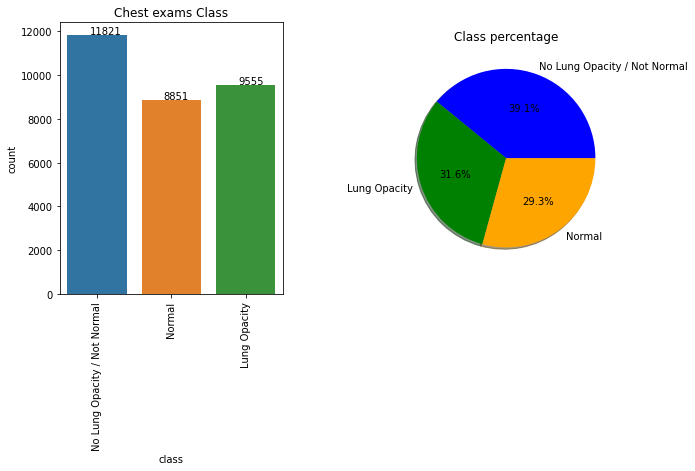

In [23]:
#Visualize the split in class based on Detail Class Information
plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
ax = sns.countplot(merge_info_df['class'])
plt.xticks(rotation=90)
plt.title('Chest exams Class')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+.3, p.get_height()+ 50))  

# Check the class Distribution
plt.subplot(1, 2, 2)

class_pie=merge_info_df['class'].value_counts()

labels = (np.array(class_pie.index))
sizes = (np.array((class_pie / class_pie.sum())*100))
colors = ['blue', 'green','orange']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=0)
plt.title("Class percentage")
plt.subplots_adjust(wspace=0.5)
plt.show()

**from the above graph, we can clarly see that:**
- Maximum examinations are reported as 'No Lung Opacity/Not Normal' with 39.1%
- 'Lung Opacity' in second at 31.6%
- 'Normal' with 29.3%

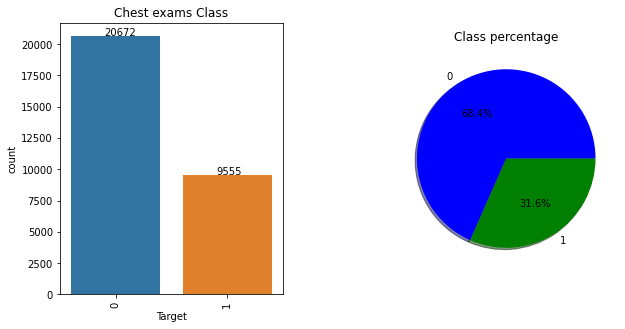

In [24]:
#Visualize the number of cases confirmed or not from the training table
plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
ax = sns.countplot(merge_info_df['Target'])
plt.xticks(rotation=90)
plt.title('Chest exams Class')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))  

# Check the class Distribution
plt.subplot(1, 2, 2)

class_pie=merge_info_df['Target'].value_counts()

labels = (np.array(class_pie.index))
sizes = (np.array((class_pie / class_pie.sum())*100))
colors = ['blue', 'green']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=0)
plt.title("Class percentage")
plt.subplots_adjust(wspace=0.5)
plt.show()

This indicates that close to 70% who went throught the test for pnuemonia comes out Negative

<Figure size 432x288 with 0 Axes>

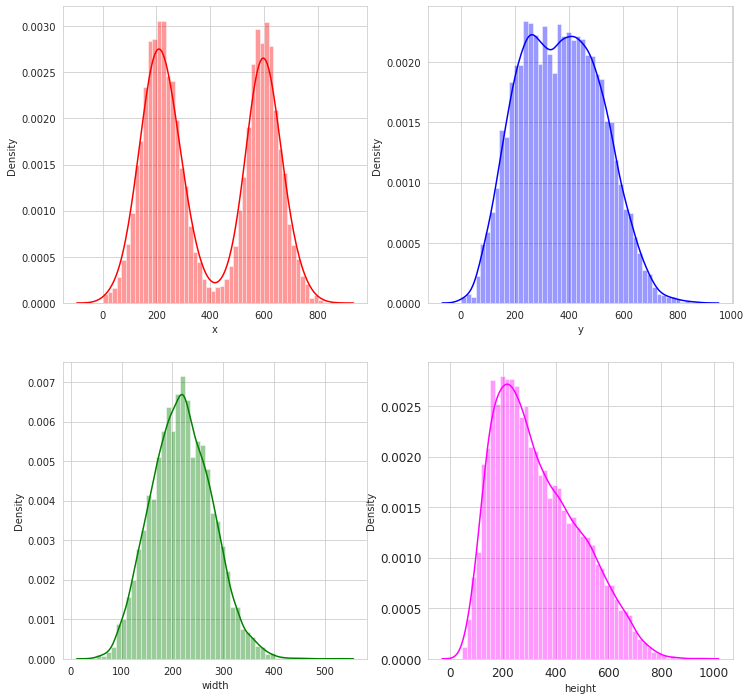

In [25]:
# plot density
target1 = merge_info_df[merge_info_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

**Feature Engineering**

In [26]:
df_areas = train_labels.dropna()[['x', 'y', 'width', 'height']].copy()
df_areas['x_2'] = df_areas['x'] + df_areas['width']
df_areas['y_2'] = df_areas['y'] + df_areas['height']
df_areas['x_center'] = df_areas['x'] + df_areas['width'] / 2
df_areas['y_center'] = df_areas['y'] + df_areas['height'] / 2
df_areas['area'] = df_areas['width'] * df_areas['height']

df_areas.head()

,x,y,width,height,x_2,y_2,x_center,y_center,area
4,264.0,152.0,213.0,379.0,477.0,531.0,370.5,341.5,80727.0
5,562.0,152.0,256.0,453.0,818.0,605.0,690.0,378.5,115968.0
8,323.0,577.0,160.0,104.0,483.0,681.0,403.0,629.0,16640.0
9,695.0,575.0,162.0,137.0,857.0,712.0,776.0,643.5,22194.0
14,288.0,322.0,94.0,135.0,382.0,457.0,335.0,389.5,12690.0


Lets check the relationship between these features

In [27]:
def createJointplot(class_pie, x, y):
    sns.jointplot(x = x, y = y, data = class_pie, kind = 'hex', gridsize = 20)
    plt.show()

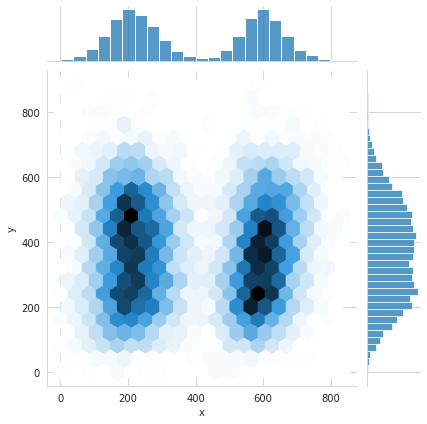

In [28]:
createJointplot(df_areas,'x','y')

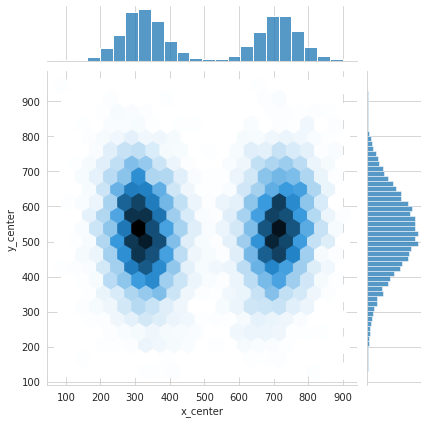

In [29]:
createJointplot(df_areas,'x_center','y_center')

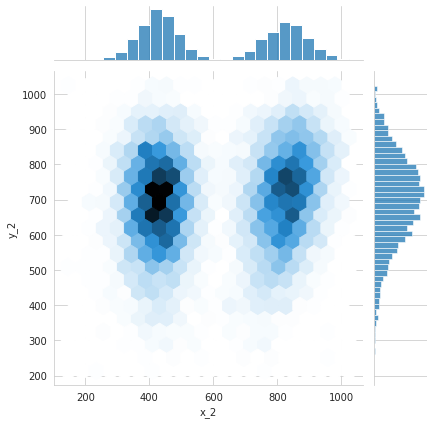

In [30]:
createJointplot(df_areas,'x_2','y_2')

As seen above, there is no significant correlation between the points (x,y) and (x_2, y_2). Let's also study the correlation between width and height.

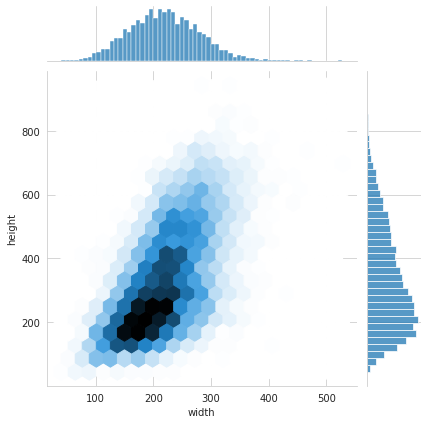

In [31]:
createJointplot(df_areas,'width','height')

As we can see from the above joint plot, width and height have high correlation, so while building a model, we can choose to keep only one of the 2 for increasing the simplicity of the model.

**Outlier Analysis**

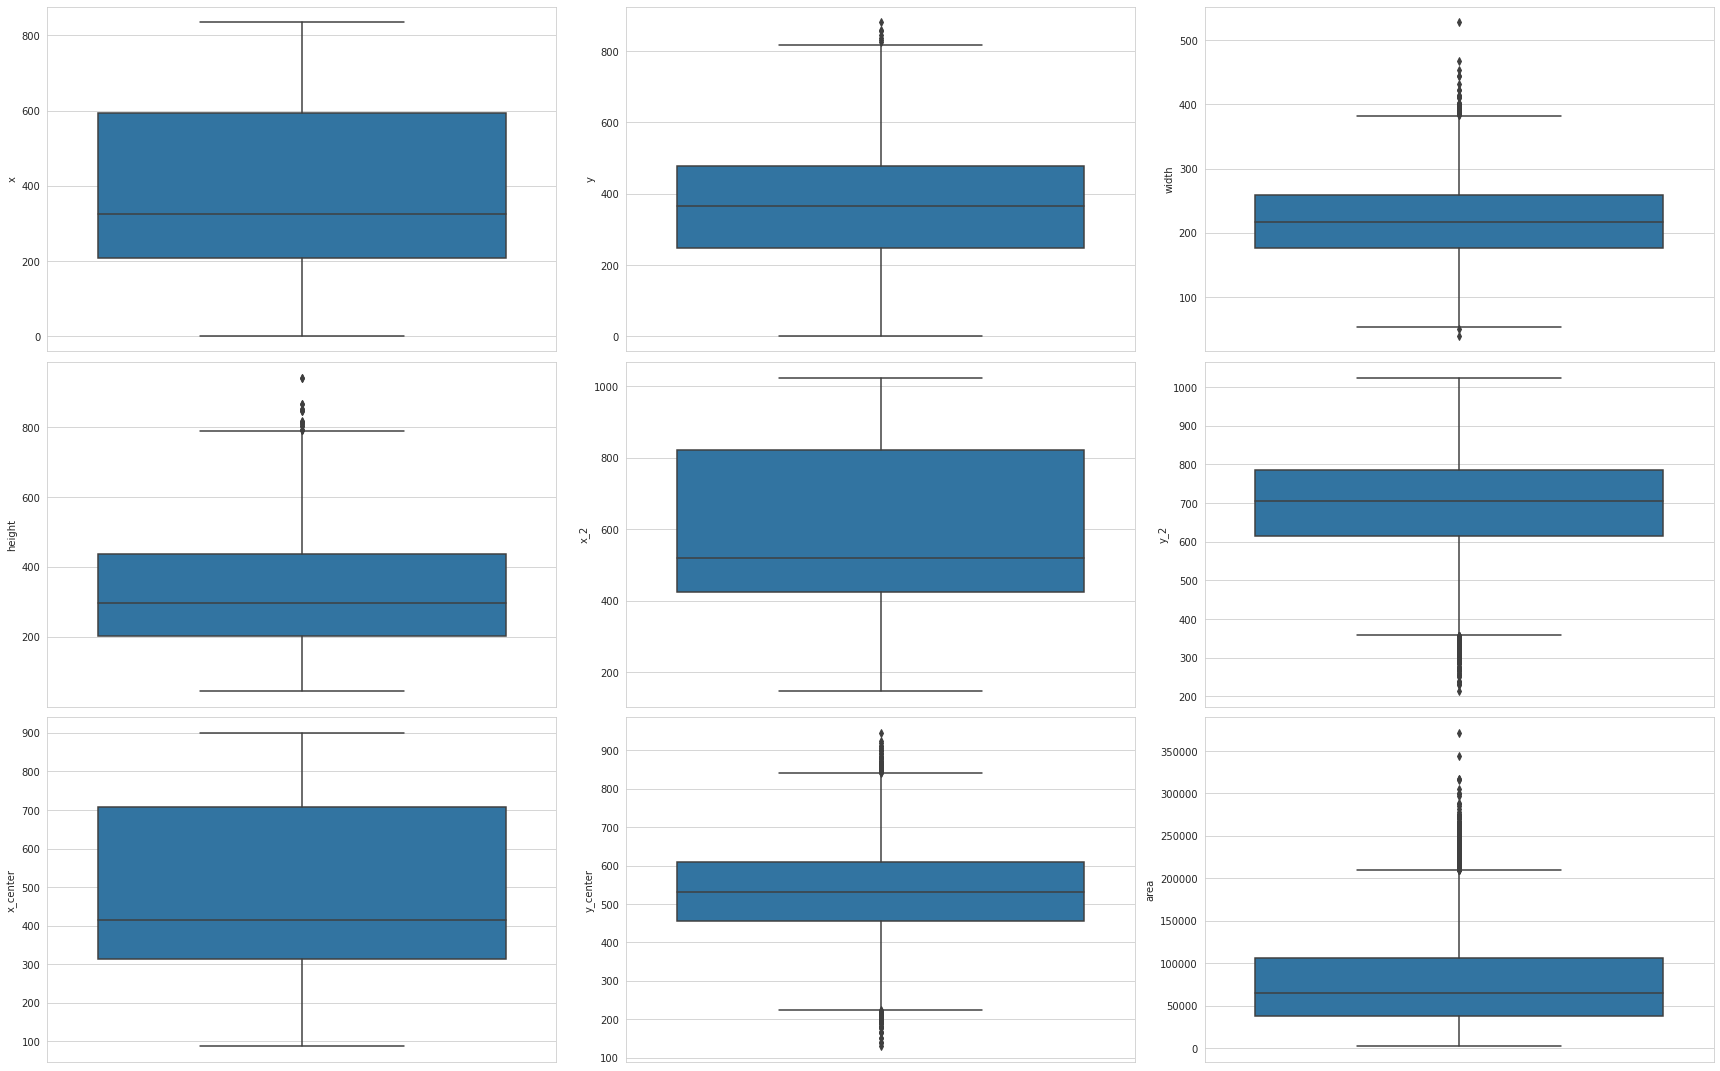

In [32]:
n_columns = 3
n_rows = 3
_, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 5 * n_rows))
for i, c in enumerate(df_areas.columns):
    sns.boxplot(y = c, data = df_areas, ax = axes[i // n_columns, i % n_columns])
plt.tight_layout()
plt.show()

In [33]:
df_areas[df_areas['width'] > 500]

,x,y,width,height,x_2,y_2,x_center,y_center,area
678,226.0,189.0,528.0,703.0,754.0,892.0,490.0,540.5,371184.0


In [34]:
pid_width = list(merge_info_df[merge_info_df['width'] > 500]['patientId'].values)
merge_info_df[merge_info_df['patientId'].isin(pid_width)]

,index,patientId,x,y,width,height,Target,class
859,678,097788d4-cb88-4457-8e71-0ca7a3da2216,226.0,189.0,528.0,703.0,1,Lung Opacity


In [35]:
df_areas[df_areas['height'] > 900].shape[0]

2

In [36]:
pid_height = list(merge_info_df[merge_info_df['height'] > 900]['patientId'].values)
merge_info_df[merge_info_df['patientId'].isin(pid_height)]

,index,patientId,x,y,width,height,Target,class
5256,4097,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,87.0,104.0,310.0,793.0,1,Lung Opacity
5257,4098,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,549.0,82.0,280.0,942.0,1,Lung Opacity
5516,4358,3e62e51c-befb-4a66-b28e-fc469b19e4a8,620.0,82.0,335.0,942.0,1,Lung Opacity
5517,4357,3e62e51c-befb-4a66-b28e-fc469b19e4a8,148.0,87.0,366.0,867.0,1,Lung Opacity


In [37]:
df = merge_info_df[~merge_info_df['patientId'].isin(pid_width + pid_height)]
df.shape

(30222, 8)

In [38]:
df.head()

,index,patientId,x,y,width,height,Target,class
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
1,28989,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal
2,28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity
3,28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity
4,28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity


DICOM Data exploration

In [39]:
!ls

'GCP Credits Request Link - RSNA.txt'   stage_2_train_images
 stage_2_detailed_class_info.csv        stage_2_train_labels.csv
 stage_2_sample_submission.csv	        stage_3_test_images
 stage_2_test_images		        stage_3_train_images


In [40]:
print("Unique patientId in  train_class_df: ", merge_info_df['patientId'].nunique())

Unique patientId in  train_class_df:  26684


DICOM Information from Image

In [41]:
samplePatientID = list(merge_info_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join(project_path+'stage_2_train_images',samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [42]:
im = dicom_file_dataset.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

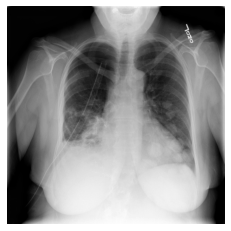

In [43]:
plt.imshow(im, cmap=plt.cm.gist_gray)
plt.gray()
plt.axis('off')

In [44]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(project_path+'stage_2_train_images',patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

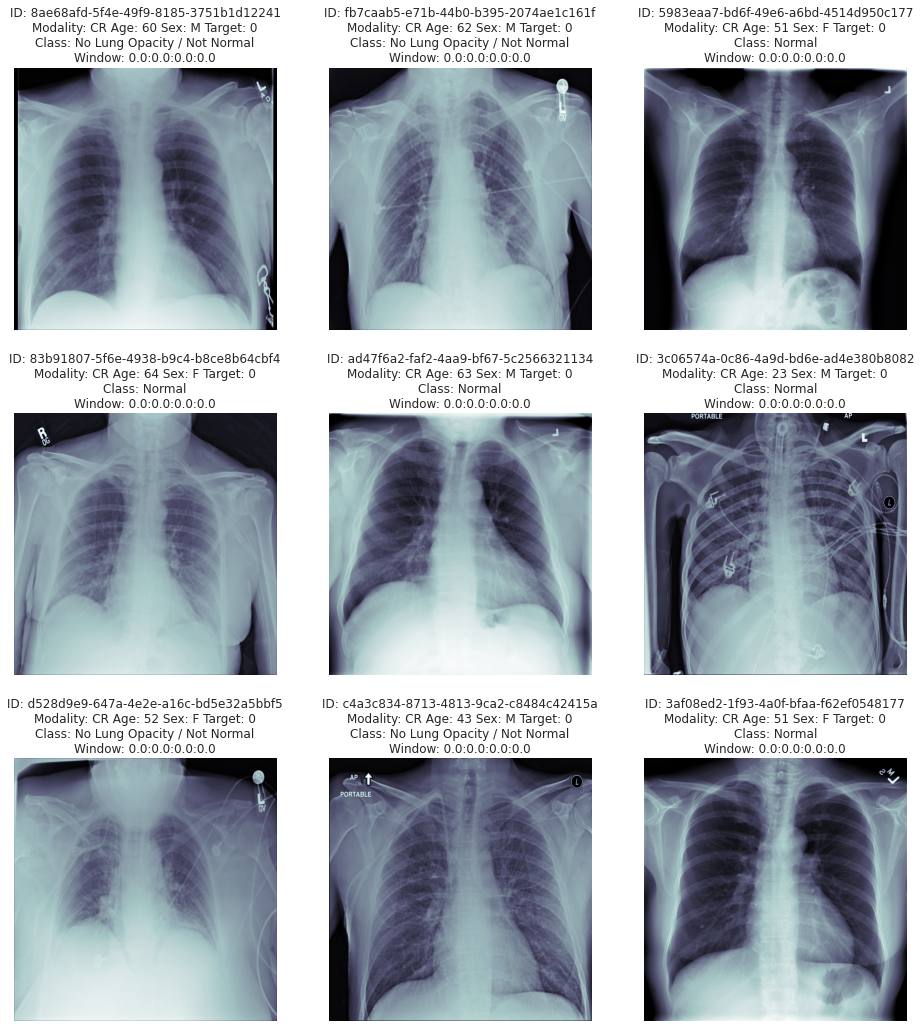

In [45]:
show_dicom_images(merge_info_df[merge_info_df['Target']==0].sample(9))

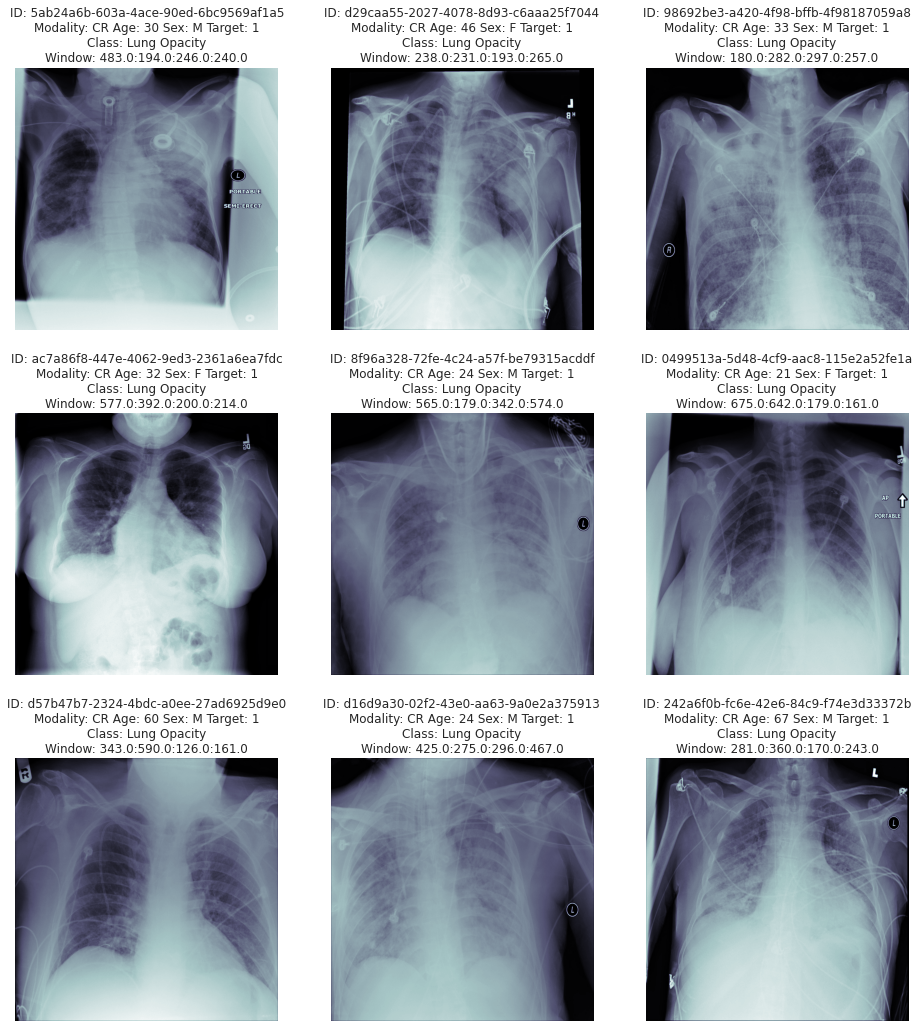

In [46]:
show_dicom_images(merge_info_df[merge_info_df['Target']==1].sample(9))

In [47]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(project_path+'stage_2_train_images',patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = merge_info_df[merge_info_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

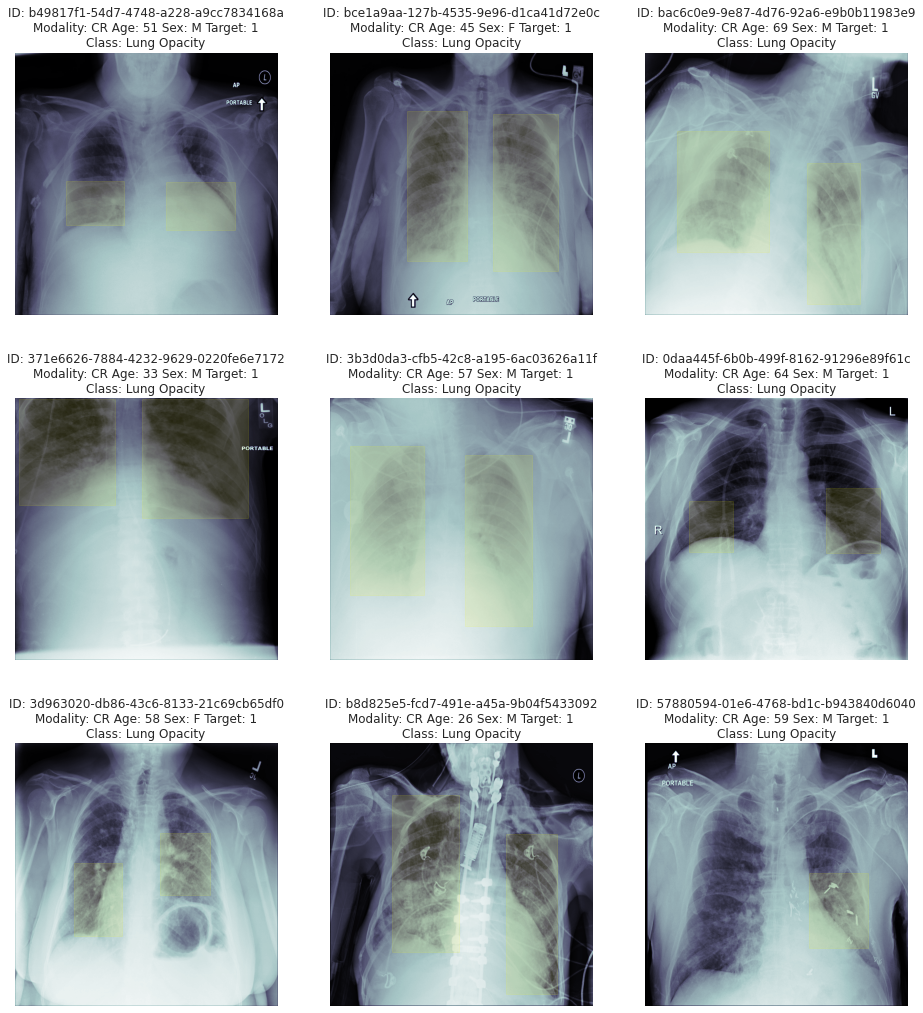

In [48]:
show_dicom_images_with_boxes(merge_info_df[merge_info_df['Target']==1].sample(9))

**We will parse the DICOM meta information and add it to the train dataset**

In [49]:
vars = [ 'PatientAge', 'PatientSex', 'ViewPosition'] #['Modality','BodyPartExamined',, 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(project_path+data_path)
    for i, img_name in tqdm(enumerate(image_names)):
        imagePath = os.path.join(project_path,data_path,img_name)
        data_row_img_data = dcm.read_file(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        #data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        #data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        #data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        #data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        #data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
        #data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0]) 



**Image metadata push to merge dataframe**

In [50]:
#Image metadata push to train labels
process_dicom_data(merge_info_df,'stage_2_train_images/')


In [51]:
train_merge_info_df = merge_info_df
train_merge_info_df.head(5)

,index,patientId,x,y,width,height,Target,class,PatientAge,PatientSex,ViewPosition
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,51,F,PA
1,28989,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal,19,F,AP
2,28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,25,F,AP
3,28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,25,F,AP
4,28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,40,M,AP


**Metadata visualization**

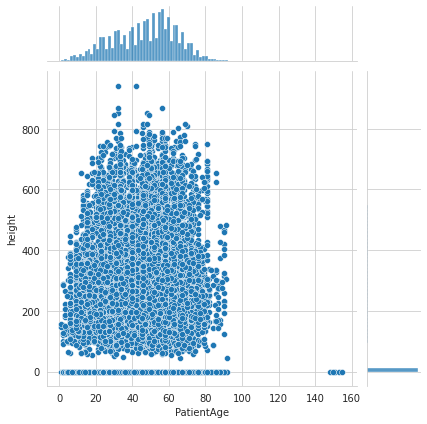

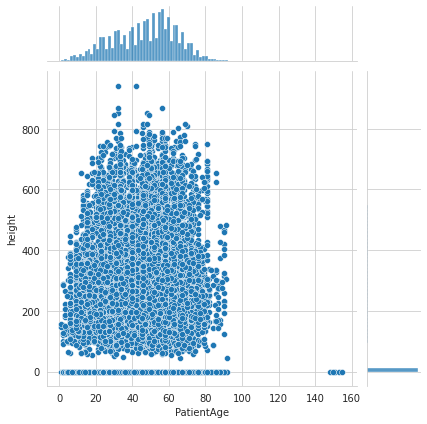

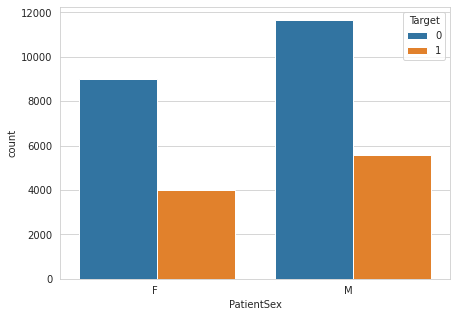

In [52]:
sns.jointplot(train_merge_info_df['PatientAge'],train_merge_info_df['height']);

sns.jointplot(train_merge_info_df['PatientAge'],train_merge_info_df['height']);

ax =plt.figure(figsize =(7,5))
ax = sns.countplot(train_merge_info_df['PatientSex'],hue=train_merge_info_df['Target'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");

**Let's check if all the entries are valid**

In [53]:
print(start+'Age:\n'+end,train_merge_info_df['PatientAge'].sort_values(ascending=False).unique())
print(start+'width:\n'+end,train_merge_info_df['width'].sort_values(ascending=False).unique())
print(start+'height:\n'+end,train_merge_info_df['height'].sort_values(ascending=False).unique())
#print(start+'Modality:\n'+end,train_merge_info_df['Modality'].sort_values(ascending=False).unique())
print(start+'Sex:\n'+end,train_merge_info_df['PatientSex'].sort_values(ascending=False).unique())
#print(start+'BodyPartExamined:\n'+end,train_merge_info_df['BodyPartExamined'].sort_values(ascending=False).unique())
print(start+'ViewPosition:\n'+end,train_merge_info_df['ViewPosition'].sort_values(ascending=False).unique())
#print(start+'ConversionType:\n'+end,train_merge_info_df['ConversionType'].sort_values(ascending=False).unique())
#print(start+'Rows:\n'+end,train_merge_info_df['Rows'].sort_values(ascending=False).unique())
#print(start+'Columns:\n'+end,train_merge_info_df['Columns'].sort_values(ascending=False).unique())
#print(start+'PixelSpacing:\n'+end,train_merge_info_df['PixelSpacing'].sort_values(ascending=False).unique())

Age:
 [155 153 151 150 148 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75
 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51
 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27
 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1]
width:
 [528. 467. 454. 445. 432. 423. 422. 414. 413. 412. 410. 403. 402. 401.
 398. 397. 396. 395. 394. 393. 392. 389. 388. 387. 386. 384. 383. 382.
 381. 380. 379. 378. 377. 376. 375. 374. 373. 372. 371. 370. 369. 367.
 366. 365. 364. 363. 362. 361. 360. 359. 358. 357. 356. 355. 354. 353.
 352. 351. 350. 349. 348. 347. 346. 345. 344. 343. 342. 341. 340. 339.
 338. 337. 336. 335. 334. 333. 332. 331. 330. 329. 328. 327. 326. 325.
 324. 323. 322. 321. 320. 319. 318. 317. 316. 315. 314. 313. 312. 311.
 310. 309. 308. 307. 306. 305. 304. 303. 302. 301. 300. 299. 298. 297.
 296. 295. 294. 293. 292. 291. 290. 289. 288. 287. 286. 285. 284. 283.
 282. 281. 280. 279. 278. 277. 276. 275. 274. 273. 272.

**Entry looks fine except for the Age. There are age more than 145 which may be wrong. lets explore**

In [54]:
checkAge = train_merge_info_df[train_merge_info_df['PatientAge'] >= 145].sort_values(['PatientAge'],ascending=False)
print(checkAge)
print(start + '\u0332'.join('\nNumber of Entries whose Age is more than 145 years:')+end,checkAge['PatientAge'].count().sum())

       index                             patientId  ...  PatientSex  ViewPosition
28984  27746  f632328d-5819-4b29-b54f-adf4934bbee6  ...           F            PA
18372  17213  a4e8e96d-93a6-4251-b617-91382e610fab  ...           M            PA
12191  11032  73aeea88-fc48-4030-8564-0a9d7fdecac4  ...           F            PA
27726  26488  ec3697bd-184e-44ba-9688-ff8d5fbf9bbc  ...           M            PA
5080    3921  3b8b8777-a1f6-4384-872a-28b95f59bf0d  ...           M            PA

[5 rows x 11 columns]

̲N̲u̲m̲b̲e̲r̲ ̲o̲f̲ ̲E̲n̲t̲r̲i̲e̲s̲ ̲w̲h̲o̲s̲e̲ ̲A̲g̲e̲ ̲i̲s̲ ̲m̲o̲r̲e̲ ̲t̲h̲a̲n̲ ̲1̲4̲5̲ ̲y̲e̲a̲r̲s̲: 5


***It will have not any impact due to wrong entry of age. so let ignore it***

**Cross - check if there are any common record in Train and Test Data sets**

In [60]:
# check if there are any common patientId in test and train data set
tmp = train_merge_info_df[['patientId','Target']]
test_merge_info_df1 = test_labels.merge(tmp,on='patientId',how = 'inner').sort_values(['patientId'],ascending=True).reset_index()
test_merge_info_df1.count()

index               0
patientId           0
PredictionString    0
Target              0
dtype: int64

*The image available in the train and test are not the same*

**Visualize the image metadata**

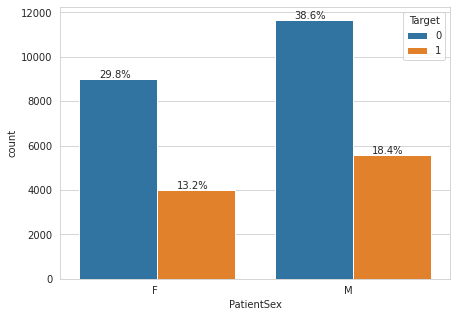

In [61]:
train_merge_info = train_merge_info_df
#sns.barplot(train_merge_info_df['PatientSex'],train_merge_info_df['class'], hue=train_merge_info_df['Target'])
plt.figure(figsize =(7,5))
ax = sns.countplot(train_merge_info['PatientSex'],hue=train_merge_info['Target'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");
 
total = len(train_merge_info['patientId'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x()+.1
        y = p.get_y()+50 + p.get_height()
        ax.annotate(percentage, (x, y))
plt.show()

The above graph indicates:
- More Male gone througt the test compare to female
- More Positive on male

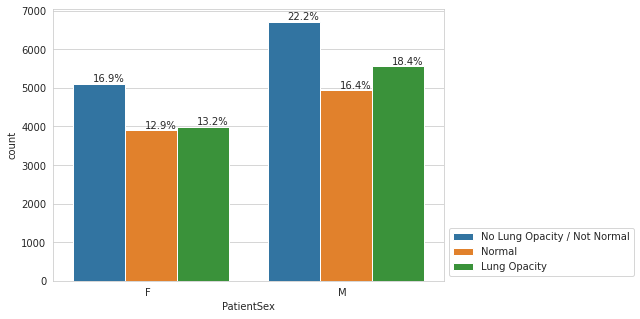

In [62]:
#print(sns.countplot(train_merge_info_df['PatientSex'],hue=train_merge_info_df['class']))

plt.figure(figsize =(7,5))
ax = sns.countplot(train_merge_info['PatientSex'],hue=train_merge_info['class'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");
 
total = len(train_merge_info['PatientSex'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x()+.1
        y = p.get_y()+50 + p.get_height()
        ax.annotate(percentage, (x, y))
# Put a legend to the right of the current axis
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

In [63]:
tmp =train_merge_info.groupby(['Target', 'PatientAge'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','Target', 'PatientAge']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()

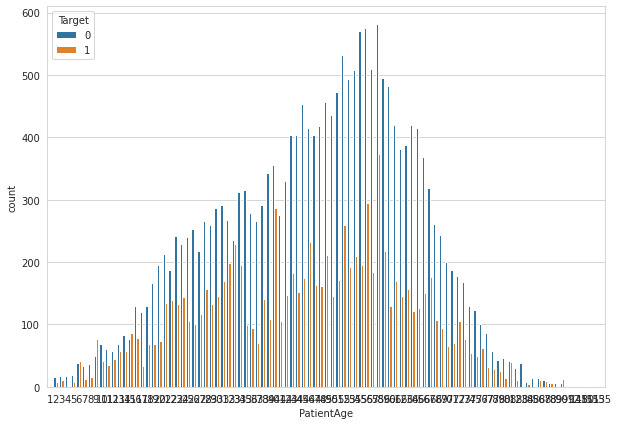

In [64]:
# Creating histogram 
fig, ax = plt.subplots(figsize =(10, 7)) 
sns.countplot(train_merge_info_df['PatientAge'],hue=train_merge_info_df['Target'])
# Show plot 
plt.show()

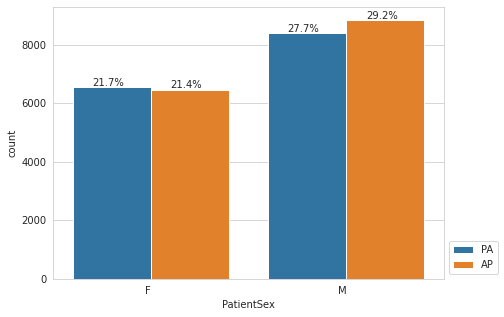

In [65]:
plt.figure(figsize =(7,5))
ax = sns.countplot(train_merge_info['PatientSex'],hue=train_merge_info['ViewPosition'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");
 
total = len(train_merge_info['PatientSex'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x()+.1
        y = p.get_y()+50 + p.get_height()
        ax.annotate(percentage, (x, y))
# Put a legend to the right of the current axis
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

**EDA - Findings**

After exploring the data, both the labels and DICOM images, we were able to:

- discover duplications in the class information and deleted
- NaNs in x , y , width and height are replaced with 0
- explore the DICOM images and extract meta information from the DICOM images
- add features to the tabular data from the meta information in DICOM images
- no files present in train dataset and test dataset matches
- 5 records who age are more than 145 yrs - which i assumed is wrong even thought it will not have any impact as such
- further analyze the distribution of the data with the newly added features from DICOM metadata

Few findings:
- Male undergo test more compare to women around 60:40 ratio
- Maximum examinations are reported as 'No Lung Opacity/Not Normal' with 39.1%, 'Lung Opacity' in second at 31.6% and 'Normal' with 29.3%
- Around 45% turns out Positive result for both sexes
- Age around 50-60 yrs has done maximum test and has maximum positive